# Conditioning Routines

Conditioning in the context of gravitational wave waveform generation means to taper the start and the end of the waveform. Generally in the conditioning routines we generate a waveform at a slightly lower frequency than the given starting frequency to avoid loosing information due to the tapering.

## Conditioning tests

* LALSuite has four different conditioning routines which have been ported to python. 
    * Generate conditioned time domain wavefrom from time domain waveform - generate_conditioned_td_waveform_from_td
    * Generate conditioned time domain wavefrom from frequency domain waveform - generate_conditioned_td_waveform_from_fd
    * Generate conditioned frequency domain wavefrom from time domain waveform - generate_conditioned_fd_waveform_from_td
    * Generate conditioned frequency domain wavefrom from frequency domain waveform - generate_conditioned_fd_waveform_from_fd

* This notebook tests the validity of each of these routines with the routines implemented in LALSuite by applying the various conditioning functions listed above from gwsignal to waveforms generated by LAL and comparing the output with waveforms already conditioned from LALSuite.

* For this, we define a notebook-specific LALCBC generator where the 'condition' parameter is hardcoded to zero and the "conditioning_routines" metadata entry is gwsignal to ensure the generator output is always a unconditioned waveform and then GenerateTD/FDWaveform routines can apply gwsignal conditioning

In [1]:
# Import base python packages
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import lalsuite packages
import lalsimulation as lalsim
import lal

# Import GWSignal packagess
import lalsimulation.gwsignal as gw
import lalsimulation.gwsignal.core.utils as ut
import lalsimulation.gwsignal.core.waveform as wfm

# Import astropy and GWPy 
import astropy.units as u
from gwpy.timeseries import TimeSeries


In [2]:
# We need to define the lal generator with hardcoded condition=0 to test gwsignal conditioning routines

In [3]:
class LALCompactBinaryCoalescenceGenerator_ForConditioningTest(wfm.LALCompactBinaryCoalescenceGenerator):
    """
    Generator class for all CBC waveforms as implemented in LALSimulation.
    """

    def __init__(self, approximant, implementation_domain=None):
        """
        Initialize class. Parent class is the "CompactBinaryCoalescenceGenerator" class

        Parameters
        ----------
        approximant : type 'str'
                    Name of the LAL approximant of which waveform to be generated

        Returns
        -------
        generator : Python GW generator class
                  Generator class for LALSimulation waveforms required to generate time and frequency domain polarizations and modes

        """
        super(LALCompactBinaryCoalescenceGenerator_ForConditioningTest, self).__init__(approximant)
        self.approximant = approximant
        self._get_approximant(self.approximant)
        self._generation_domain = None
        self.implementation_domain = implementation_domain
        self._update_domains()

    @property

    def metadata(self):
        metadata = {
            "type": 'cbc_lalsimulation',
            "f_ref_spin": True,
            "modes": True,
            "polarizations": True,
            "implemented_domain": self._implemented_domain,
            "generation_domain": self._generation_domain,
            "approximant" : self._approx_name,
            "implementation" : "LALSimulation",
            "conditioning_routines" : 'gwsignal'
        }
        return metadata
    def generate_td_waveform(self, **parameters):
        """
        Perform parameter check, choose lalsimulation generator based on domain and conditioning subroutines.

        Parameters
        ----------
        parameter_dict : dictionary
            Dictionary of waveform parameters of the form specified
            in `parameter_conventions.py`.

        Returns
        -------
        hp, hc : LAL Time Series
            Plus and cross polarizations of a gravitational waveform (hp,hc) as LAL Data objects.

        Raises
        ------
            ValueError if domain ('time' or 'freq') for approximant is not specified
        """
        self.parameter_check(**parameters)
        parameters['condition']=0
        if self._implemented_domain=='time':
            self._pol_gen_function = lalsim.SimInspiralGenerateTDWaveform

        elif self._implemented_domain=='freq':
            if self._generation_domain=='time' and parameters['condition']==1:
                self._pol_gen_function = lalsim.SimInspiralGenerateTDWaveform
            elif self._generation_domain=='time' and parameters['condition']==0:
                raise ValueError("Generator requires conditioning to be turned on to generate time domain waveform")

        self._lal_generator = lalsim.SimInspiralChooseGenerator(self._approx, self.lal_dict)

        def gen_pol_func(lal_dict, lal_generator):
            return self._pol_gen_function(lal_dict, lal_generator)

        hp, hc = gen_pol_func(self.lal_dict, self._lal_generator)
        hp, hc = wfm.to_gwpy_Series(hp, name='hplus'), wfm.to_gwpy_Series(hc, name='hcross')
        return hp, hc

    def generate_fd_waveform(self, **parameters):
        """
        Perform parameter check, choose lalsimulation generator based on domain and conditioning subroutines.

        Parameters
        ----------
        parameter_dict : dictionary
            Dictionary of waveform parameters of the form specified
            in `parameter_conventions.py`.

        Returns
        -------
        hp, hc : LAL Frequency Series
            Plus and cross polarizations of a gravitational waveform (hp,hc) as LAL Data objects.

        Raises
        ------
            ValueError if domain ('time' or 'freq') for approximant is not specified
        """
        self.parameter_check(**parameters)
        parameters['condition']=0
        if self._implemented_domain=='time':
            if self._generation_domain=='freq' and parameters['condition']==1:
                self._pol_gen_function = lalsim.SimInspiralGenerateFDWaveform
            elif self._generation_domain=='freq' and parameters['condition']==0:
                raise ValueError("Generator requires conditioning to be turned on to generate frequency domain waveform")

        elif self._implemented_domain=='freq':
            self._pol_gen_function = lalsim.SimInspiralGenerateFDWaveform

        self._lal_generator = lalsim.SimInspiralChooseGenerator(self._approx, self.lal_dict)

        def gen_pol_func(lal_dict, lal_generator):
            return self._pol_gen_function(lal_dict, lal_generator)

        hp, hc = gen_pol_func(self.lal_dict, self._lal_generator)
        hp, hc = wfm.to_gwpy_Series(hp, name='hplus', epoch=0.), wfm.to_gwpy_Series(hc, name='hcross', epoch=0.)
        return hp, hc


In [4]:
# Match function with a flat PSD
from scipy.interpolate import InterpolatedUnivariateSpline as IUS
from scipy.integrate import simpson
def get_match(sig1, sig2):
    
    # Prepare data
    if isinstance(sig1, TimeSeries):
        sig1 = sig1.fft()
    
    if isinstance(sig2, TimeSeries):
        sig2 = sig2.fft()
    
    if np.all(sig1.frequencies==sig2.frequencies):
        freq_array = np.array(sig1.frequencies)
    else:
        # Interpolate the waveform and resample at fixed frequency array.
        print("Frequency arrays not the same.... interpolating")
        freq_array = np.array(sig1.frequencies)
        freq2 = np.array(sig2.frequencies)
        
        #_sig2 = IUS(freq2, np.array(sig2))
        sig2 = np.interp(freq_array, freq2, np.array(sig2))
        #sig2 = _sig2(freq_array)
    
    psd = np.ones(len(freq_array))
    
    inner_prod = lambda n1, n2 : np.abs(simpson(2*(n1*n2.conj() + n2*n1.conj())/psd, freq_array))
    
    sig1 = sig1/np.sqrt(inner_prod(sig1, sig1))
    sig2 = sig2/np.sqrt(inner_prod(sig2, sig2))
    
    # Maximize over overall phase
    phis = np.linspace(0, np.pi, 100)
    matches=[]
    for ph in phis:
        sig3 = sig2*np.exp(1j*ph)
        matches.append(inner_prod(sig1, sig3))
    return np.max(matches)

## Conditioned td from td waveform

This block tests the output of the GWsignal function `generate_conditioned_td_waveform_from_td()` and compares it with LALSuite output

In [5]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'IMRPhenomTPHM'


In [6]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [7]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant)

/home/chinmay.kalaghatgi/.conda/envs/lalsuite-dev/lib/python3.10/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [8]:
hp, hc = wfm.GenerateTDWaveform(python_dict, gen)

In [9]:
hp2, hc2 = wfm.GenerateTDWaveform(python_dict, gen_test)

/home/chinmay.kalaghatgi/.conda/envs/lalsuite-dev/lib/python3.10/site-packages/lalsimulation/gwsignal/core/waveform.py:623: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


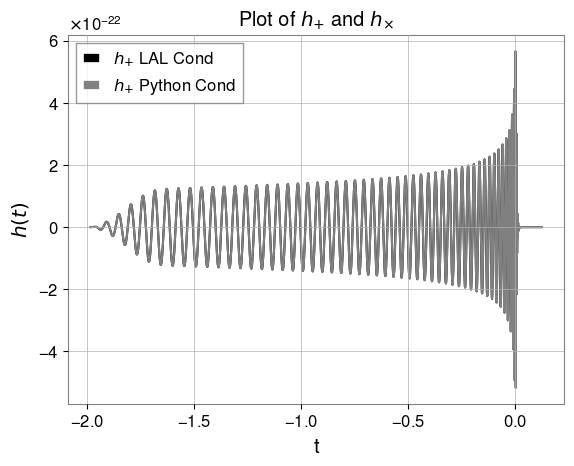

In [10]:
plt.plot(hp , 'black' ,label=r'$h_{+}$ LAL Cond')
plt.plot(hp2 , 'gray', label=r'$h_{+}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')


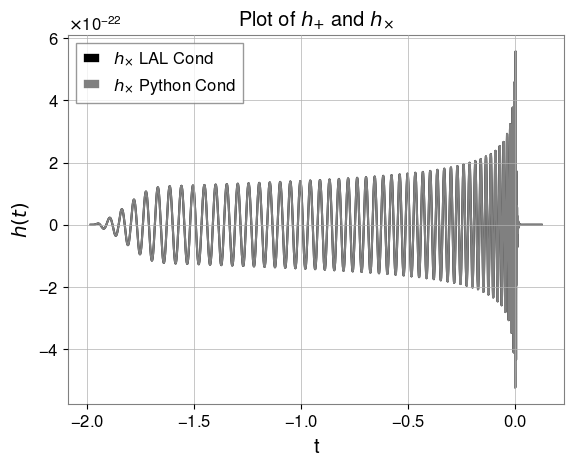

In [11]:
plt.plot(hc , 'black' ,label=r'$h_{\times}$ LAL Cond')
plt.plot(hc2 , 'gray', label=r'$h_{\times}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')

In [12]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [13]:
get_match(sig_lal, sig_gw)

/home/chinmay.kalaghatgi/.conda/envs/lalsuite-dev/lib/python3.10/site-packages/numpy/fft/_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


0.9999999817006819

## Conditioned fd waveform from td waveform

This block tests the output of the GWsignal function `generate_conditioned_fd_waveform_from_td()` and compares it with LALSuite output

In [14]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaF = 1./1024.*u.Hz
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
f_max = 2048.*u.Hz

distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'IMRPhenomTPHM'


In [15]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaF' : deltaF,
              'f22_start' : f_min,
              'f22_ref': f_ref,
               'f_max' : f_max,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [16]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant)

In [17]:
hp, hc = wfm.GenerateFDWaveform(python_dict, gen)

In [18]:
hp2, hc2 = wfm.GenerateFDWaveform(python_dict, gen_test)

/home/chinmay.kalaghatgi/.conda/envs/lalsuite-dev/lib/python3.10/site-packages/lalsimulation/gwsignal/core/waveform.py:660: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


(10, 1000.0)

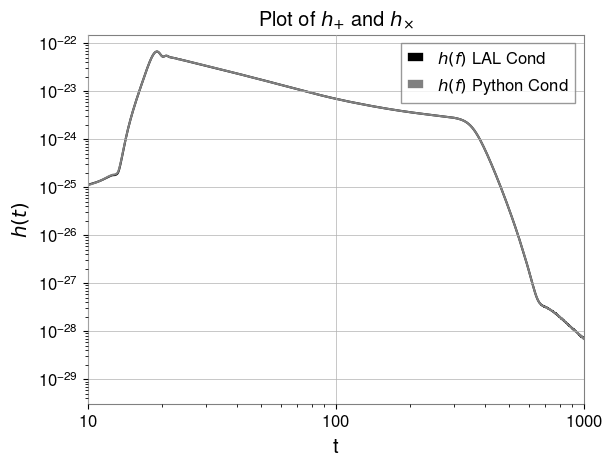

In [19]:
plt.loglog(hp.frequencies, abs(hp+1j*hc) , 'black' ,label=r'$h(f)$ LAL Cond')
plt.loglog(hp2.frequencies, abs(hp2+1j*hc2) , 'gray', label=r'$h(f)$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')
plt.xlim(10, 1e3)

In [20]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [21]:
get_match(sig_lal, sig_gw)

0.9999999842436637

## Conditioned fd waveform from fd waveform

This block tests the output of the GWsignal function `generate_conditioned_fd_waveform_from_fd()` and compares it with LALSuite output

In [22]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaF = 1./1024.*u.Hz
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
f_max = 2048.*u.Hz

distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'IMRPhenomXPHM'


In [23]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaF' : deltaF,
              'f22_start' : f_min,
              'f22_ref': f_ref,
               'f_max' : f_max,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [24]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant, 'freq')

In [25]:
hp, hc = wfm.GenerateFDWaveform(python_dict, gen)

In [26]:
hp2, hc2 = wfm.GenerateFDWaveform(python_dict, gen_test)

(10, 1000.0)

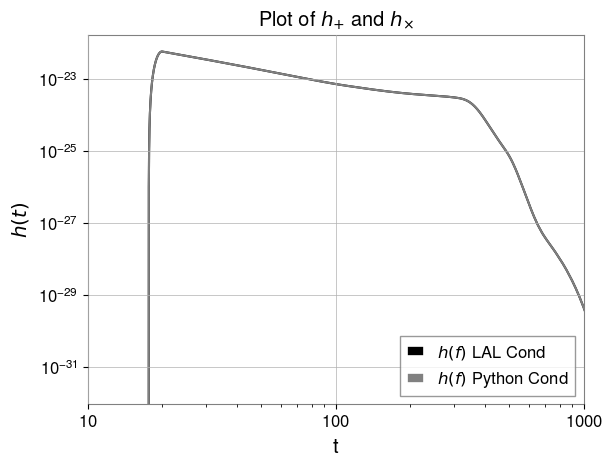

In [27]:
plt.loglog(hp.frequencies, abs(hp+1j*hc) , 'black' ,label=r'$h(f)$ LAL Cond')
plt.loglog(hp2.frequencies, abs(hp2+1j*hc2) , 'gray', label=r'$h(f)$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')
plt.xlim(10, 1e3)

In [28]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [29]:
get_match(sig_lal, sig_gw)

1.0

## Conditioned td waveform from fd waveform

This block tests the output of the GWsignal function `generate_conditioned_td_waveform_from_fd()` and compares it with LALSuite output

* Here, we cannot do a apples to apples comparison. Basically, the way conditioning works in LALSimulation; if a generator template has a generate_td_waveform function; it will first enter `generate_conditioned_td_waveform_from_td` which enters `XLALSimInspiralChooseTDWaveform_legacy` which then enters `XLALSimInspiralTDFromFD`. The comparison we do will not then be exactly equal.
* However this can be replicated for IMRPhenom waveforms using the code below. 

In [30]:
# This requires generating conditioned FD waveform. But our generator has condition hard-coded to 0.
# Simple workaround - use the conditioning function to generate the fd waveform and convert to td.

import lalsimulation.gwsignal.core.conditioning_subroutines  as cond

def generate_conditioned_td_waveform_from_fd(parameter_dict, generator):
    """
    Function to generate conditioned time-domain waveform from frequency domain waveform model.

    Parameters
    ----------
    parameter_dict : dictionary
            Dictionary of intrinsic / extrinsic gravitational wave parameters
    generator : Python GW generator class
            Generator class for the waveform approximant (either LAL or external)

    Returns
    -------
    hp, hc : GWpy Time series
            Conditioned time domain polarizations
    """

    extra_time_fraction = 0.1   # fraction of waveform duration to add as extra time for tapering
    extra_cycles = 3.0          # more extra time measured in cycles at the starting frequency

    dt = parameter_dict['deltaT'].value
    original_f_min = f_min = parameter_dict['f22_start'].value
    f_ref = parameter_dict['f22_ref'].value
    f_max = 0.5/dt
    s1z   = parameter_dict['spin1z'].value
    s2z   = parameter_dict['spin2z'].value

    m1    = parameter_dict['mass1'].si.value
    m2    = parameter_dict['mass2'].si.value

    # Fix reference frequency to fmin/ case by case for Python generators. It is set to zero for lalsim generators as LALSim has its
    # own checks.
    if np.isclose(f_ref, 0):
        f_ref = fix_ref_frequency(parameter_dict, generator)

    # If lowest freq. is below fisco, set fmin to fisco.
    fisco = 1.0 / (np.power(9.0, 1.5) * np.pi * (m1 + m2) * lal.MTSUN_SI / lal.MSUN_SI)
    if (f_min > fisco):
        f_min = fisco

    # Upper chrip time bound
    tchirp = lalsim.SimInspiralChirpTimeBound(f_min, m1, m2, s1z, s2z)

    # Upper bound on the final black hole spin
    s = lalsim.SimInspiralFinalBlackHoleSpinBound(s1z, s2z)

    # Upper bound on the final plunge, merger, and ringdown time
    tmerge = lalsim.SimInspiralMergeTimeBound(m1, m2) + lalsim.SimInspiralRingdownTimeBound(m1 + m2, s)

    # extra time to include for all waveforms to take care of situations
    # where the frequency is close to merger (and is sweeping rapidly):
    # this is a few cycles at the low frequency
    textra = extra_cycles / f_min

    # Generate frequency domain conditioned waveform with deltaF = 0 to get
    # enough frequency resolution.

    new_parameters = parameter_dict.copy()
    new_parameters['f22_start'] = f_min*u.Hz
    new_parameters['f22_ref'] = f_ref*u.Hz
    new_parameters['f_max'] = f_max*u.Hz
    new_parameters['deltaF'] = 0.*u.Hz

    # Generate the new waveform
    new_parameters['condition']=1
    hp, hc = wfm.GenerateFDWaveform(new_parameters, generator)


    # We want to make sure that this waveform will give something
    # sensible if it is later transformed into the time domain:
    # to avoid the end of the waveform wrapping around to the beginning,
    # we shift waveform backwards in time and compensate for this
    # shift by adjusting the epoch -- note that the conditioned
    # generate_fd_waveform method guarantees that there is the
    # extra padding to do this

    tshift = np.round(textra / dt) * dt # integer number of samples

    kvals = np.arange(0, len(hp))
    phase_shift = np.exp(2*np.pi*1j*hp.df.value*tshift*kvals)
    hp *= phase_shift
    hc *= phase_shift

    if hp.epoch==None or hc.epoch==None:
        hp.epoch=tshift*u.s
        hc.epoch=tshift*u.s
    else:
        hp.epoch+=tshift*u.s
        hc.epoch+=tshift*u.s

    # transform the waveform into the time domain
    hpt = hp.ifft()*2*hp.df
    hct = hc.ifft()*2*hp.df

    # High pass timeseries
    hpt = cond.high_pass_time_series(hpt, dt, original_f_min, 0.99, 8.)
    hct = cond.high_pass_time_series(hct, dt, original_f_min, 0.99, 8.)

    # Resize time series
    fstart = lalsim.SimInspiralChirpStartFrequencyBound((1.0 + extra_time_fraction) * tchirp, m1, m2);
    tchirp = lalsim.SimInspiralChirpTimeBound(fstart, m1, m2, s1z, s2z);

    #total expected chirp length includes merger

    chirplen = round((tchirp + tmerge) /dt)
    end = len(hpt) - np.round(tshift/dt)

    # snip off extra time at beginning and at the end
    hpt = cond.resize_gwpy_timeseries(hpt, end - chirplen, chirplen)
    hct = cond.resize_gwpy_timeseries(hct, end - chirplen, chirplen)

    # # final tapering at the beginning and at the end to remove filter transients
    fisco = 1.0 / (np.power(6.0, 1.5) * np.pi * (m1 + m2) * lal.MTSUN_SI / lal.MSUN_SI)
    hpt, hct = cond.time_array_condition_stage2(hpt, hct, dt, f_min, fisco)

    return hpt, hct



def generate_conditioned_td_waveform_from_td(parameter_dict, generator):
    """
    Function to generate conditioned time-domain waveform from time domain waveform model.

    Parameters
    ----------
    parameter_dict : dictionary
            Dictionary of intrinsic / extrinsic gravitational wave parameters
    generator : Python GW generator class
            Generator class for the waveform approximant (either LAL or external)

    Returns
    -------
    hp, hc : GWpy Time series
            Conditioned time domain polarizations
    """

    extra_time_fraction = 0.1   # fraction of waveform duration to add as extra time for tapering
    extra_cycles = 3.0          # more extra time measured in cycles at the starting frequency

    # Get some of the required parameters and get their values (so as not to have issues with units and LAL)
    f_min = parameter_dict['f22_start'].value
    f_ref = parameter_dict['f22_ref'].value
    s1z   = parameter_dict['spin1z'].value
    s2z   = parameter_dict['spin2z'].value

    m1    = parameter_dict['mass1'].si.value
    m2    = parameter_dict['mass2'].si.value

    # Fix reference frequency to fmin/ case by case for Python generators. It is set to zero for lalsim generators as LALSim has its
    # own checks.
    if np.isclose(f_ref, 0):
        f_ref = fix_ref_frequency(parameter_dict, generator)


    # If loweset freq. is below fisco, set fmin to fisco.
    fisco = 1.0 / (np.power(9.0, 1.5) * np.pi * (m1 + m2) * lal.MTSUN_SI / lal.MSUN_SI)
    if (f_min > fisco):
        f_min = fisco


    # Upper chrip time bound
    tchirp = lalsim.SimInspiralChirpTimeBound(f_min, m1, m2, s1z, s2z)

    # Upper bound on the final black hole spin
    s = lalsim.SimInspiralFinalBlackHoleSpinBound(s1z, s2z)

    # Upper bound on the final plunge, merger, and ringdown time
    tmerge = lalsim.SimInspiralMergeTimeBound(m1, m2) + lalsim.SimInspiralRingdownTimeBound(m1 + m2, s)

    # extra time to include for all waveforms to take care of situations
    # where the frequency is close to merger (and is sweeping rapidly):
    # this is a few cycles at the low frequency
    textra = extra_cycles / f_min

    # For conditioning, start waveform at a lower frequency than f_min and then apply tapers between new low freq and f_min.
    fstart = lalsim.SimInspiralChirpStartFrequencyBound((1.0 + extra_time_fraction) * tchirp + tmerge + textra, m1, m2)

    # generate the waveform in the time domain starting at fstart. Add astropy units
    new_parameters = parameter_dict.copy()
    new_parameters['f22_ref'] = f_ref*parameter_dict['f22_start'].unit
    new_parameters['f22_start'] = fstart*parameter_dict['f22_start'].unit


    # Generate the new waveform
    new_parameters['condition']=0
    hp, hc = generate_conditioned_td_waveform_from_fd(new_parameters, generator)

    times = hp.times
    dt = hp.dt.value
    # Condition the time domain waveform by tapering in the extra time at the beginning
    # And perform the high-pass filtering
    hp, hc = cond.time_array_condition_stage1(hp, hc, dt, extra_time_fraction * tchirp + textra, parameter_dict['f22_start'].value)

    fisco = 1.0 / (np.power(6.0, 1.5) * np.pi * (m1 + m2) * lal.MTSUN_SI / lal.MSUN_SI)
    hp, hc = cond.time_array_condition_stage2(hp, hc, dt, f_min, fisco)

    return hp, hc



In [31]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'IMRPhenomXPHM'


In [32]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [33]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant, 'freq')

In [34]:
hp, hc = wfm.GenerateTDWaveform(python_dict, gen)

In [35]:
hp2, hc2 = generate_conditioned_td_waveform_from_td(python_dict, gen_test)

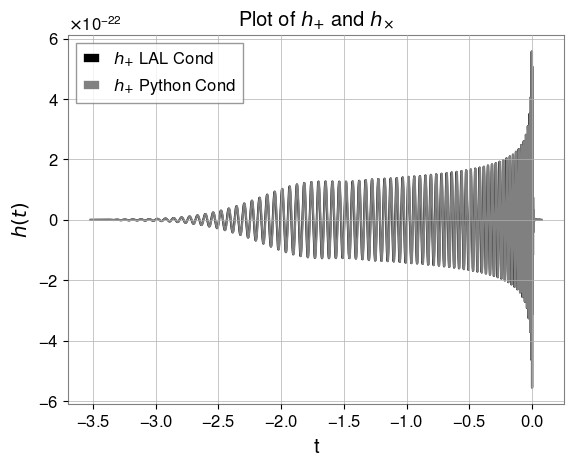

In [36]:
plt.plot(hp , 'black' ,label=r'$h_{+}$ LAL Cond')
plt.plot(hp2 , 'gray', label=r'$h_{+}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')


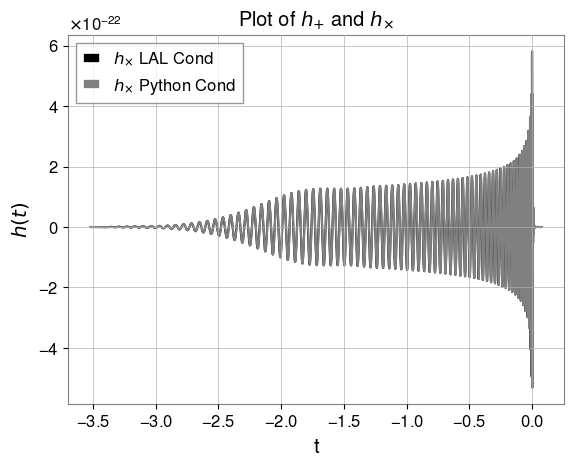

In [37]:
plt.plot(hc , 'black' ,label=r'$h_{\times}$ LAL Cond')
plt.plot(hc2 , 'gray', label=r'$h_{\times}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')

In [38]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [39]:
get_match(sig_lal, sig_gw)

0.99999999900392

* Lets try the same as above for IMRPhenomD_NRTidal

In [40]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'IMRPhenomD_NRTidal'


In [41]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [42]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)

gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant, 'freq')

In [43]:
hp, hc = wfm.GenerateTDWaveform(python_dict, gen)

In [44]:
hp2, hc2 = wfm.GenerateTDWaveform(python_dict, gen_test)

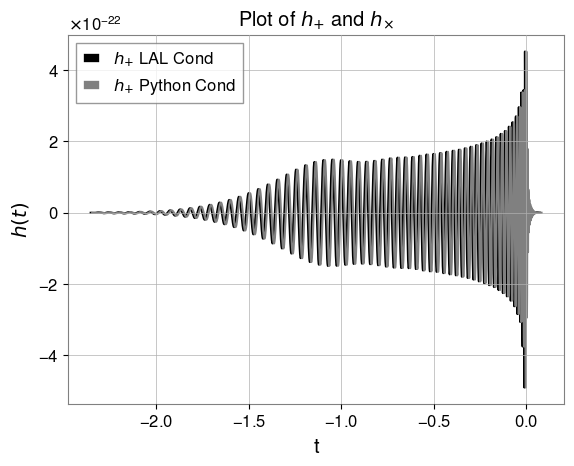

In [45]:
plt.plot(hp , 'black' ,label=r'$h_{+}$ LAL Cond')
plt.plot(hp2 , 'gray', label=r'$h_{+}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')


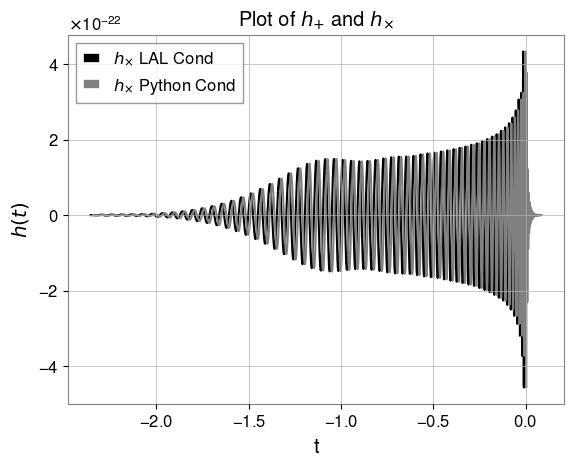

In [46]:
plt.plot(hc , 'black' ,label=r'$h_{\times}$ LAL Cond')
plt.plot(hc2 , 'gray', label=r'$h_{\times}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')

In [47]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [48]:
get_match(sig_lal, sig_gw)

0.9999999999982087

In [49]:
# Mass / spin parameters
m1 = 20.*u.solMass
m2 = 30.*u.solMass
s1x = 0.*u.dimensionless_unscaled
s1y = 0.*u.dimensionless_unscaled
s1z = 0.*u.dimensionless_unscaled
s2x = 0.*u.dimensionless_unscaled
s2y = 0.*u.dimensionless_unscaled
s2z = 0.*u.dimensionless_unscaled

deltaT = 1./1024.*u.s
f_min = 20.*u.Hz
f_ref = 20.*u.Hz
distance = 1000.*u.Mpc
inclination = 0.*u.rad
phiRef = 0.*u.rad
eccentricity = 0.*u.dimensionless_unscaled
longAscNodes = 0.*u.rad
meanPerAno = 0.*u.rad

# Whether the waveforms should be conditioned or not
condition = 1


approximant = 'SEOBNRV4'


In [62]:
python_dict = {'mass1' : m1,
              'mass2' : m2,
              'spin1x' : s1x,
              'spin1y' : s1y,
              'spin1z' : s1z,
              'spin2x' : s2x,
              'spin2y' : s2y,
              'spin2z' : s2z,
              'deltaT' : deltaT,
              'f22_start' : f_min,
              'f22_ref': f_ref,
              'phi_ref' : phiRef,
              'distance' : distance,
              'inclination' : inclination,
              'eccentricity' : eccentricity,
              'longAscNodes' : longAscNodes,
              'meanPerAno' : meanPerAno,
              'condition' : condition}


In [63]:
gen = wfm.LALCompactBinaryCoalescenceGenerator(approximant)


gen_test = LALCompactBinaryCoalescenceGenerator_ForConditioningTest(approximant, 'freq')

In [64]:
hp, hc = wfm.GenerateTDWaveform(python_dict, gen)

In [65]:
hp2, hc2 = wfm.GenerateTDWaveform(python_dict, gen_test)

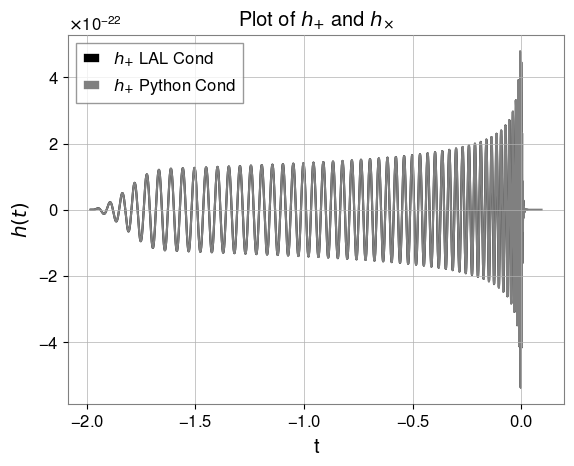

In [66]:
plt.plot(hp , 'black' ,label=r'$h_{+}$ LAL Cond')
plt.plot(hp2 , 'gray', label=r'$h_{+}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')


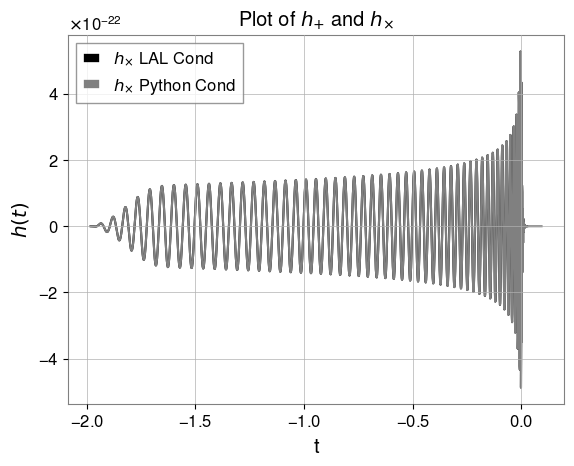

In [67]:
plt.plot(hc , 'black' ,label=r'$h_{\times}$ LAL Cond')
plt.plot(hc2 , 'gray', label=r'$h_{\times}$ Python Cond')

plt.xlabel(r't');
plt.ylabel(r'$h(t)$');
plt.title(r'Plot of $h_{+}$ and $h_{\times}$');
plt.legend(loc='best')

In [68]:
sig_lal = hp+1j*hc
sig_gw = hp2+1j*hc2

In [69]:
get_match(sig_lal, sig_gw)

Frequency arrays not the same.... interpolating


0.27505592784580407

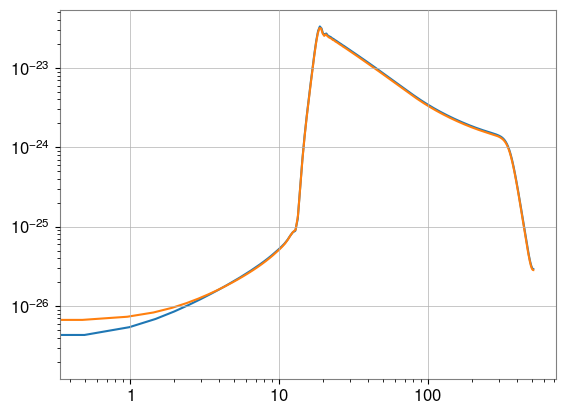

In [70]:
plt.loglog(abs(sig_lal.fft()))
plt.loglog(abs(sig_gw.fft()))